In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:

Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:

Base.classes.keys()

['measurement', 'station']

In [8]:

Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:

session = Session(engine)

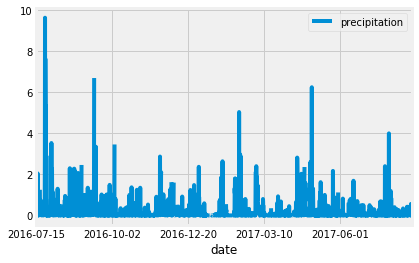

In [10]:

prev_year = dt.date(2017, 7, 15) - dt.timedelta(days=365)
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

df = df.sort_values("date")

df.plot(x_compat=True);

In [11]:

df.describe()

,precipitation
count,2238.000000
mean,0.199164
std,0.555108
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,9.640000


In [12]:

session.query(func.count(Station.station)).all()

[(9)]

In [13]:

session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

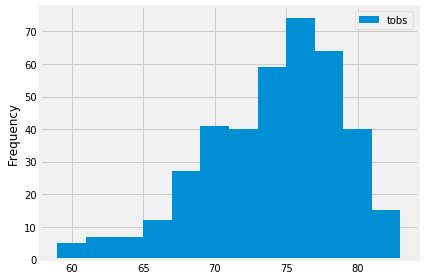

In [15]:

import datetime as dt
from pandas.plotting import table
prev_year = dt.date(2017, 7, 15) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()

In [16]:

def calc_temps(start_date, end_date):

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [17]:

import datetime as dt

prev_year_start = dt.date(2018, 7, 15) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 7, 30) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

72.0 78.78217821782178 84.0


C:\Users\mohamed\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


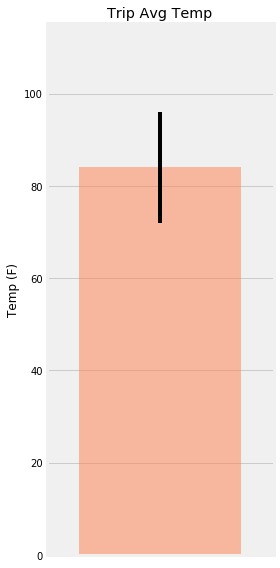

In [18]:

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [19]:


start_date = '2017-07-15'
end_date = '2017-07-30'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 11.700000000000003), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.12), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.06), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.3600000000000003), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.38), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.21000000000000002), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.01)]


In [20]:

def daily_normals(date):
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [21]:

trip_start = '2018-07-15'
trip_end = '2018-07-30'

trip_dates = pd.date_range(trip_start, trip_end, freq='D')

trip_month_day = trip_dates.strftime('%m-%d')
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(68.0, 76.2542372881356, 82.0),
 (70.0, 76.34482758620689, 83.0),
 (70.0, 76.30188679245283, 83.0),
 (72.0, 76.63793103448276, 83.0),
 (68.0, 75.89090909090909, 83.0),
 (69.0, 75.46296296296296, 82.0),
 (69.0, 76.9245283018868, 83.0),
 (69.0, 75.78846153846153, 81.0),
 (70.0, 76.20370370370371, 84.0),
 (69.0, 76.55555555555556, 81.0),
 (67.0, 76.89090909090909, 84.0),
 (71.0, 76.4423076923077, 86.0),
 (68.0, 76.58181818181818, 83.0),
 (69.0, 76.46428571428571, 82.0),
 (69.0, 76.47058823529412, 83.0),
 (69.0, 77.35185185185185, 84.0)]

In [22]:

df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2018-07-15,68.0,76.254237,82.0
2018-07-16,70.0,76.344828,83.0
2018-07-17,70.0,76.301887,83.0
2018-07-18,72.0,76.637931,83.0
2018-07-19,68.0,75.890909,83.0


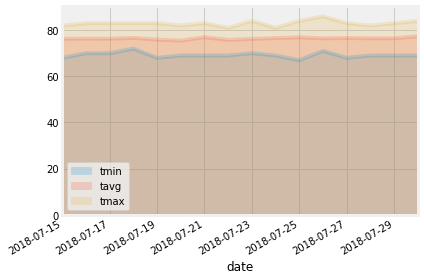

In [23]:

df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()